In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from skimage import io, img_as_ubyte
import json
import copy
from scipy.ndimage import gaussian_filter1d
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import torch
import torch.nn.functional as F
from torch.nn.utils import prune

import seaborn as sns
sns.set()

from models import get_net
from models.downsampler import Downsampler
from utils.sr_utils import *
from utils.common_utils import np_to_pil, pil_to_np, get_fname, np_to_torch

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal, prune_weights_ffg, prune_weights
import BayTorch.visualize as V

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']

In [2]:
def np_plot(xs, ys, labels=None, sigma=5, xlabel=r'iteration', ylabel='', xtlf='', ytlf='', 
            ylim=None, xlim=None, path=None, separate_legend=False, legend_cols=5):
    if labels is None:
        labels = ['' for _ in range(len(xs))]
    
    fig, ax = plt.subplots(1, 1)
    handles = []
    for x, y, l in zip(xs, ys, labels):
        if sigma > 0:
            y = gaussian_filter1d(y, sigma=sigma)
        plot = ax.plot(x, y, label=l)
        handles.append(plot[0])
    ax.set_xlabel(xlabel, fontsize=22)
    ax.set_ylabel(ylabel, fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if ylim != None:
        ax.set_ylim(ylim[0],ylim[1])
    if xlim != None:
        ax.set_xlim(xlim[0],xlim[1])
    ax.grid(True)
    if labels is not None and not separate_legend:
        ax.legend()
    
    if xtlf == 'sci':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
    if ytlf == 'sci':
        ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()
    if labels is not None and separate_legend:
        fig_l, ax_l = plt.subplots(1, 1)
        legend = ax_l.legend(handles, labels, loc='center', ncol=legend_cols)
        ax_l.grid(False)
        ax_l.set_yticks([])
        ax_l.set_xticks([])
        ax_l.set_facecolor((1., 1., 1.))
        fig_l  = legend.figure
        fig_l.canvas.draw()
        bbox  = legend.get_window_extent()
        bbox = bbox.from_extents(*(bbox.extents + np.array([-5,-5,5,5])))
        bbox = bbox.transformed(fig_l.dpi_scale_trans.inverted())
        if path is not None:
            fig_l.savefig('%s_legend.pdf' % path, dpi="figure", bbox_inches=bbox)
        plt.show()

In [3]:
def get_trained_net(net_info, train_data):
    bay_inf_type = net_info['bay_inf_type']
    
    net = get_net(net_info['num_input_channels'], 'skip', 'reflection',
              skip_n33d=net_info['num_channels_down'],
              skip_n33u=net_info['num_channels_up'],
              skip_n11=net_info['num_channels_skip'],
              num_scales=net_info['num_scales'],
              n_channels=net_info['num_output_channels'],
              upsample_mode=net_info['upsample_mode'],
              need_sigmoid=False)

    #optimizer = torch.optim.AdamW(net.parameters(), lr=net_info['lr'])
    
    if bay_inf_type == 'mc_dropout':
        net = MCDropoutVI(net, net_info['dropout_type'], net_info['dropout_p'])
    elif bay_inf_type == 'mean_field':
        prior = {'mu': net_info['prior_mu'], 'sigma': net_info['prior_sigma']}
        if net_info['prior_pi'] is not None:
            prior['pi'] = net_info['prior_pi']
        net = MeanFieldVI(net, prior=prior, kl_type='reverse')
    
    net.load_state_dict(train_data['state_dict'])
    return net.type(dtype)

In [4]:
#path_log_dir = '/home/toelle/logs'
path_log_dir = '/media/fastdata/toelle/logs_sr'

imsize = -1
factor = 4
enforce_div32 = 'CROP'

img_name = 'xray'
to_compare = 'lanczos3'
spec = 'praesi'

if img_name == 'xray':
    fname = 'data/bayesian/BACTERIA-1351146-0006.jpg'
elif img_name == 'oct':
    fname = 'data/bayesian/CNV-9997680-30.png'
elif img_name == 'us':
    fname = 'data/bayesian/081_HC.jpg'
elif img_name == 'ct':
    fname = 'data/bayesian/gt_ct.png'
elif img_name == 'mri':
    fname = 'data/bayesian/gt_mri.png'

if spec == 'praesi':
    runs = ['none_sr_%s_' % img_name, 'mean_field_sr_%s_gp_' % img_name,
        'mc_dropout_sr_%s_2d_' % img_name, 'sgld_sr_%s_' % img_name, 
        'sgld_paper_sr_%s_' % img_name]
    runs = [r + to_compare for r in runs]
    labels = [r'DIP', r'FFG GP', r'MCD 2D', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+MSE $\sigma=\eta$']    

elif to_compare in ['box', 'lanczos2', 'lanczos3', 'gauss12', 'gauss1sq2']:
    runs = ['none_sr_%s_' % img_name, 'mean_field_sr_%s_gp_' % img_name, 'mean_field_sr_%s_smp_' % img_name,
        'mc_dropout_sr_%s_2d_' % img_name, 'mc_dropout_sr_%s_g2d_' % img_name, 
        'sgld_sr_%s_' % img_name, 'sgld_sr_%s_nll_' % img_name,
        'sgld_paper_sr_%s_' % img_name, 'sgld_paper_sr_%s_nll_' % img_name]
    runs = [r + to_compare for r in runs]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']

else:
    if to_compare == 'none':
        spec = ''
    runs = ['_sr_%s%s_box' % (img_name, spec), '_sr_%s%s_lanczos2' % (img_name, spec), '_sr_%s%s_lanczos3' % (img_name, spec), 
            '_sr_%s%s_gauss12' % (img_name, spec), '_sr_%s%s_gauss1sq2' % (img_name, spec)]
    runs = [to_compare + r for r in runs]
    labels = [r'Box', r'Lanczos2', r'Lanczos3', r'Gauss $1/2$', r'Gauss $1/\sqrt{2}$']
    
imgs = load_LR_HR_imgs_sr(fname, imsize, factor, enforce_div32)

HR and LR resolutions: (256, 256), (64, 64)


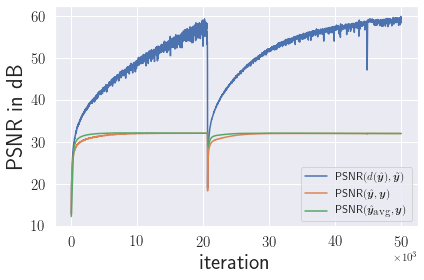

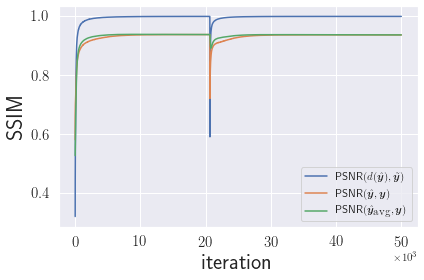

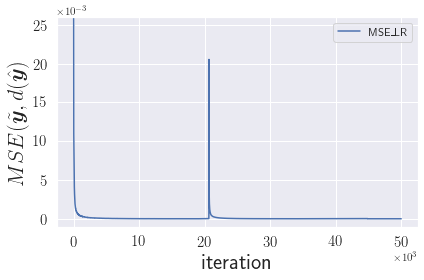

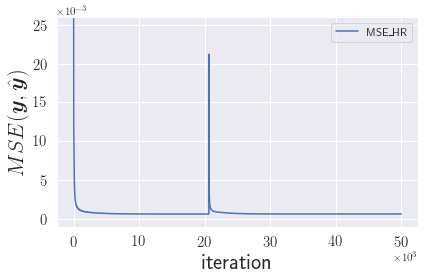

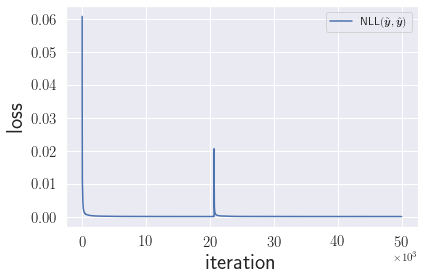

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


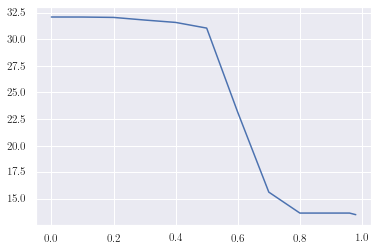

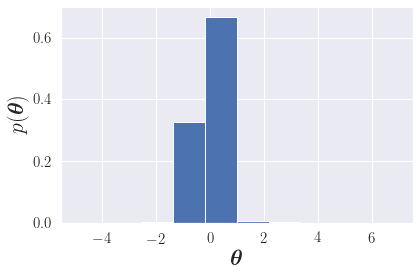

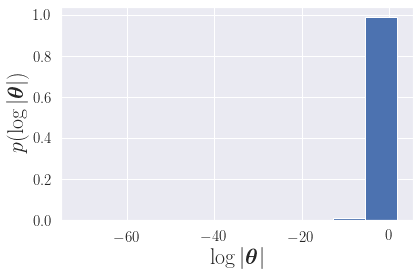

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


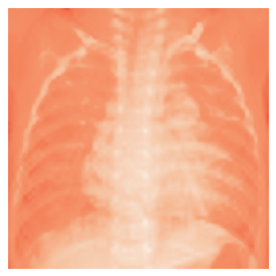

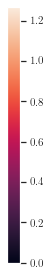

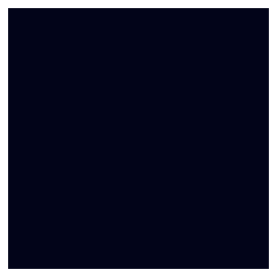

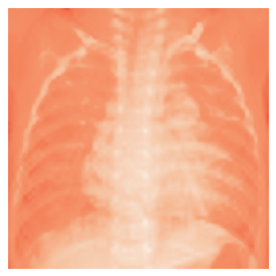

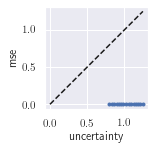

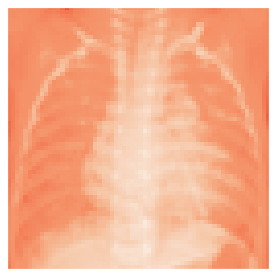

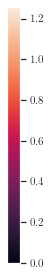

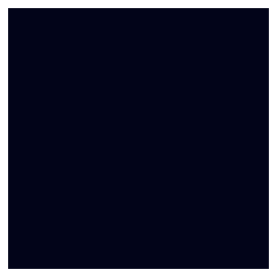

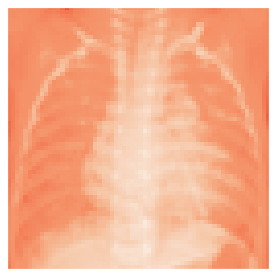

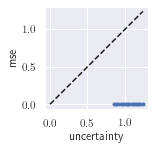

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


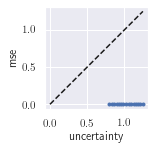

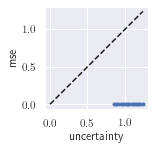

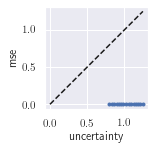

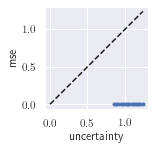

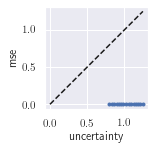

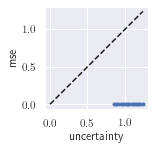

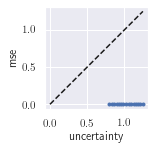

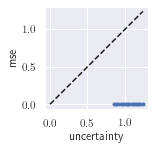

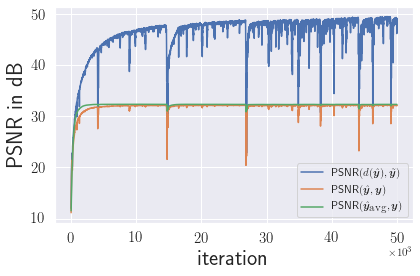

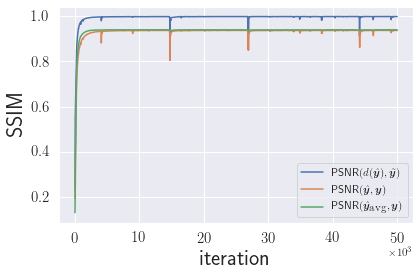

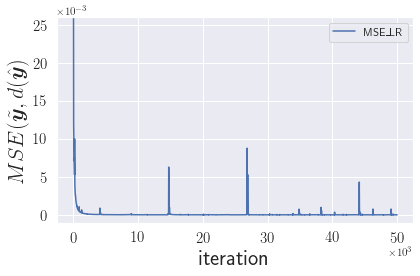

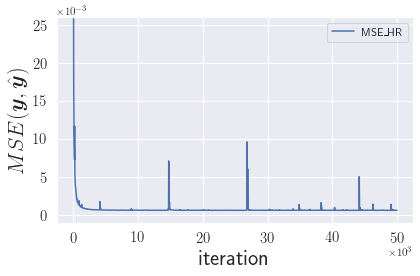

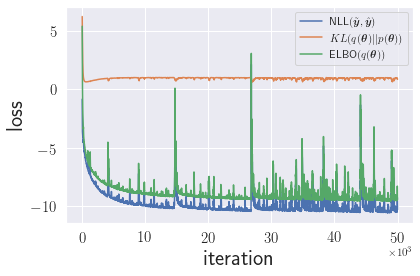

../BayTorch/inference/utils.py:118: RuntimeWarning: divide by zero encountered in log
  snrs = np.hstack((snrs, np.log(snr_np)))


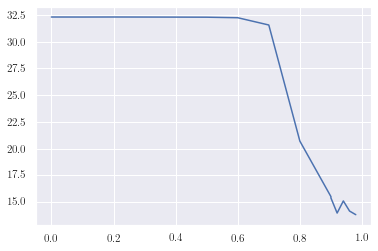

/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


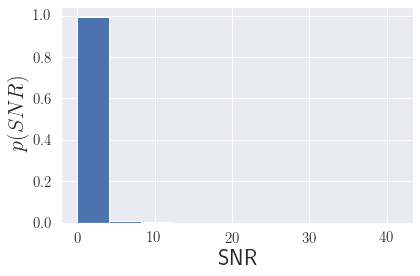

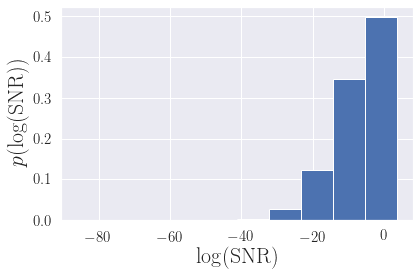

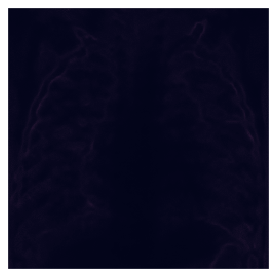

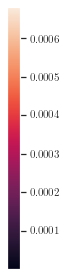

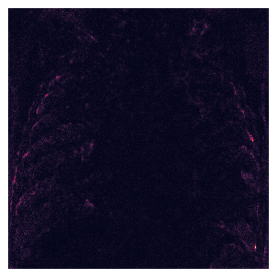

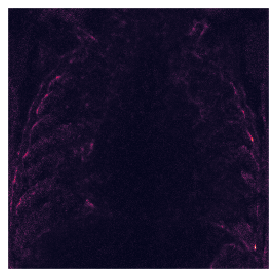

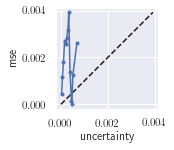

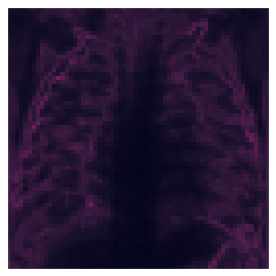

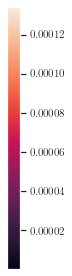

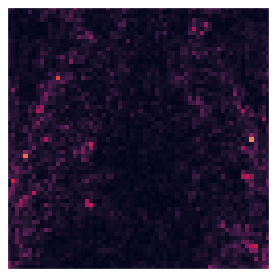

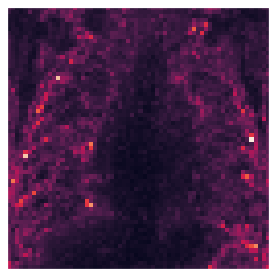

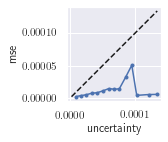

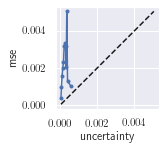

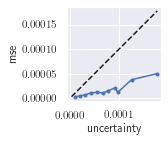

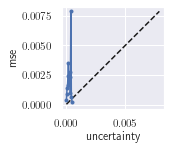

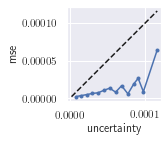

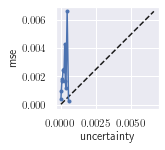

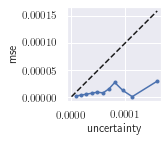

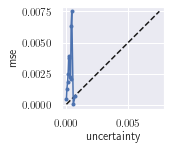

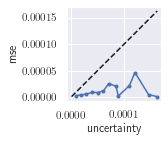

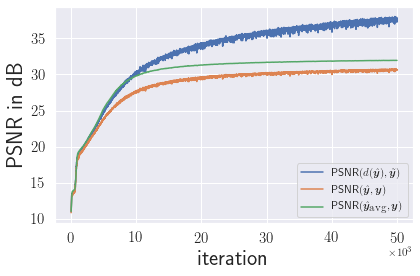

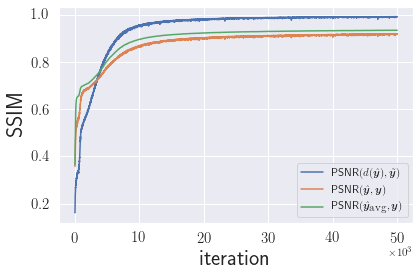

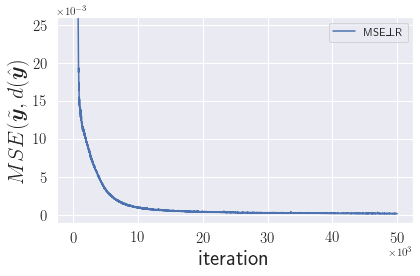

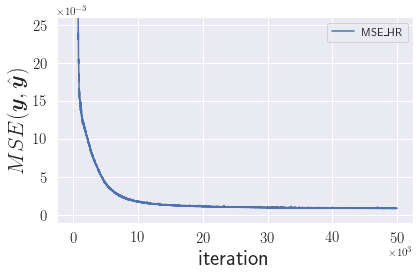

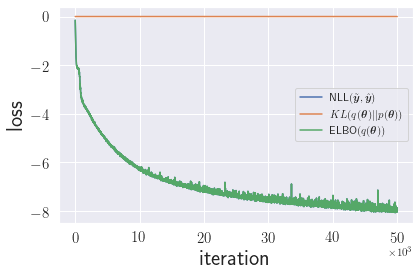

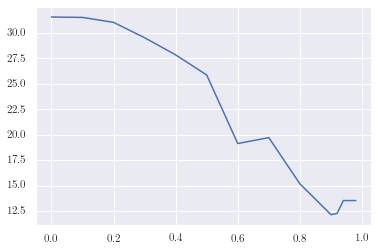

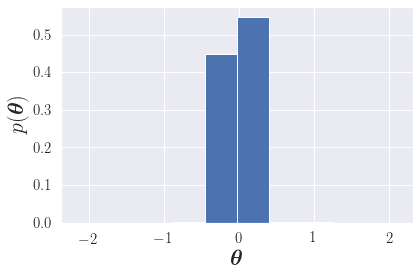

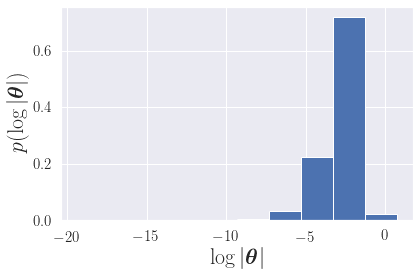

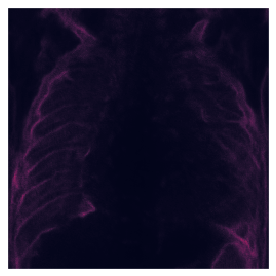

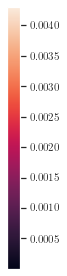

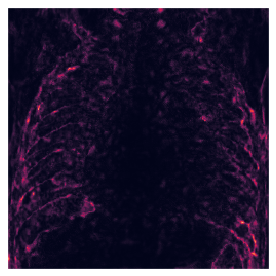

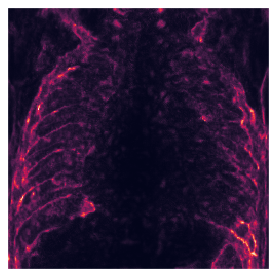

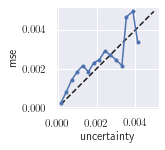

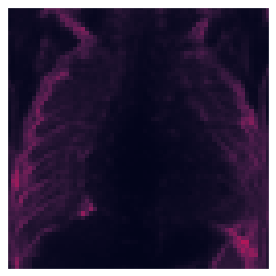

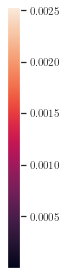

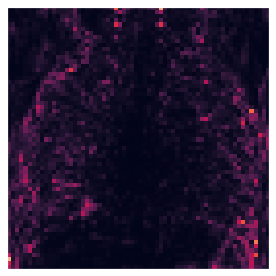

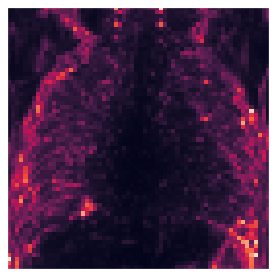

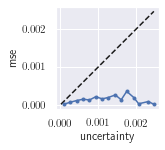

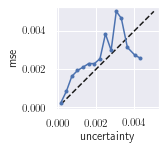

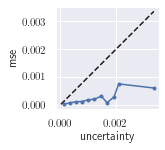

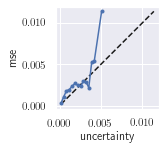

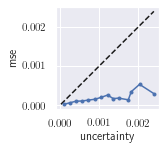

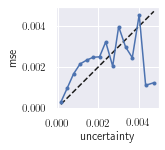

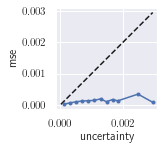

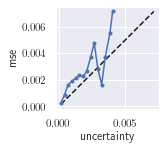

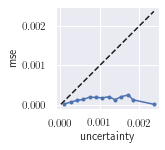

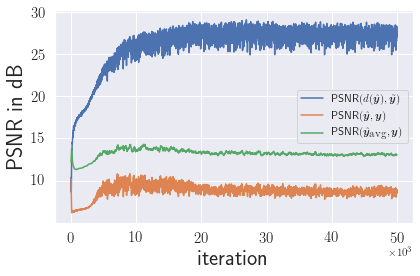

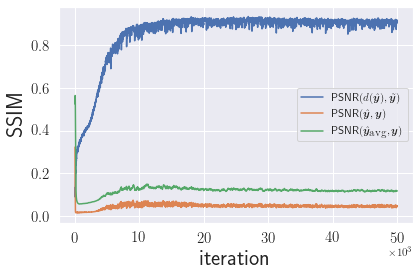

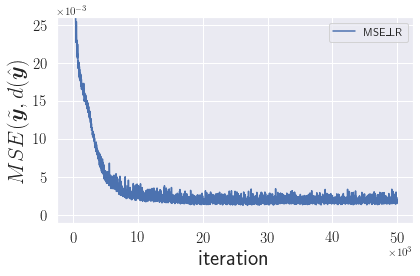

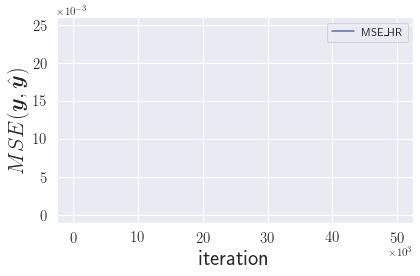

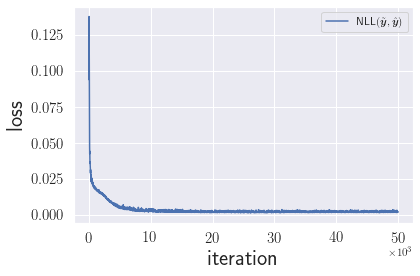

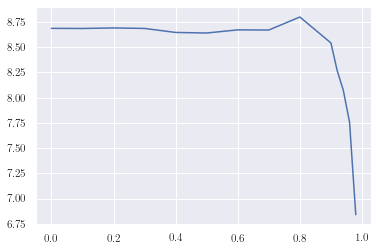

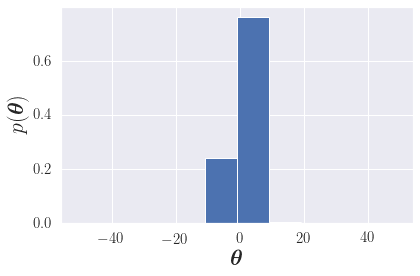

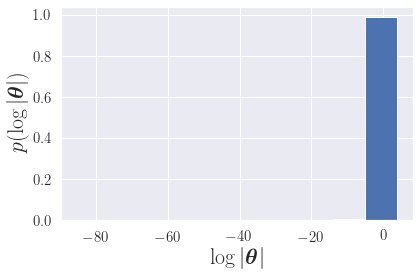

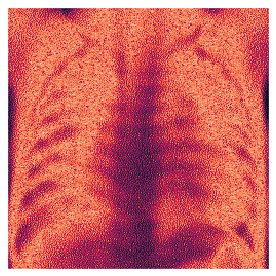

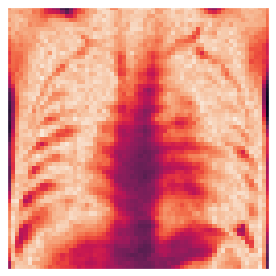

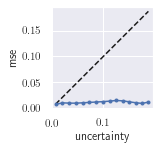

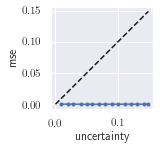

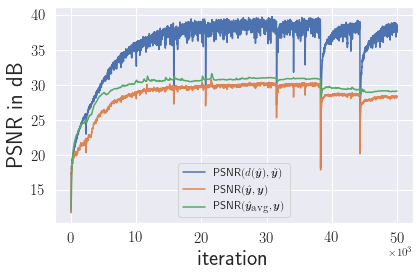

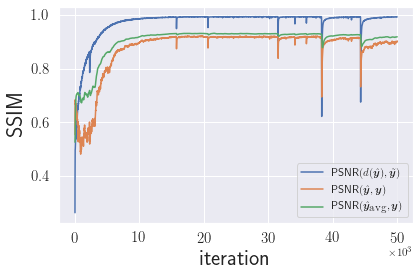

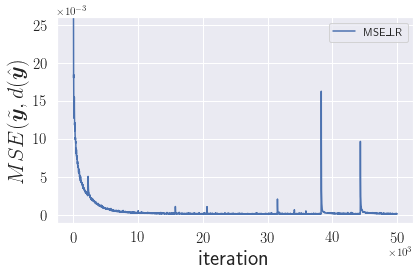

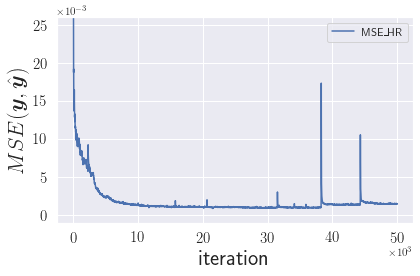

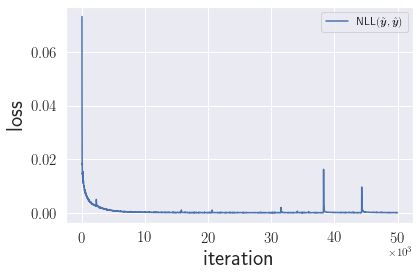

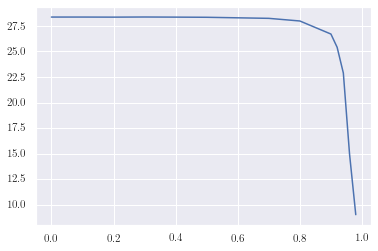

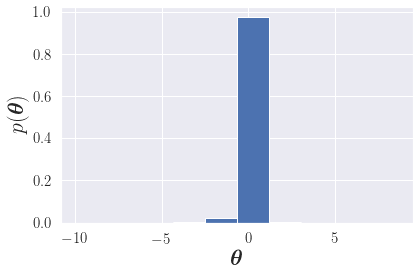

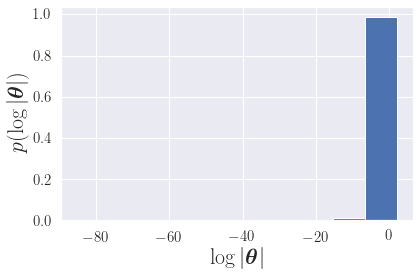

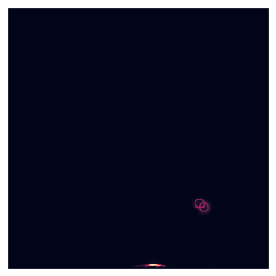

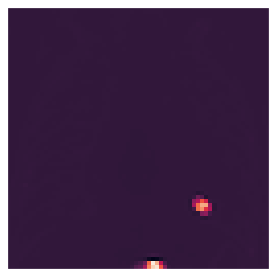

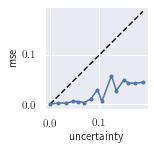

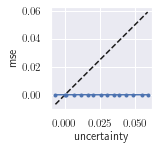

In [5]:
pruning_range = np.hstack((np.arange(0.,1.,0.1), np.arange(0.9, 1., 0.02)))
pruning = True

mc_iter = 10

losses = {}
psnrs = {}
ssims = {}
uncerts = {}
uces = {}
params = {}

ale_LR_maps = []
epi_LR_maps = []
uncert_LR_maps = []
ale_HR_maps = []
epi_HR_maps = []
uncert_HR_maps = []

for run, label in zip(runs, labels):
    train_data = torch.load('%s/%s/train_vals.pt' % (path_log_dir, run))
    net_info = json.load(open('%s/%s/net_info.json' % (path_log_dir, run)))
    image_data = np.load('%s/%s/vals.npz' % (path_log_dir, run))
    #img_np_noisy = pil_to_np(Image.open('%s/%s/noisy_img.pdf' % (path_log_dir, run)))
    
    bay_inf_type = net_info['bay_inf_type']
    kernel_type = net_info['kernel_type']
    factor = net_info['factor']
    
    downsampler = Downsampler(n_planes=imgs['LR_np'].shape[0]+1, factor=factor, 
                              kernel_type=kernel_type, kernel_width=2*factor, sigma=0.5, 
                              phase=0.5, preserve_size=True).type(dtype)
    downsampler_uncert = Downsampler(n_planes=imgs['LR_np'].shape[0], factor=factor, 
                              kernel_type=kernel_type, kernel_width=2*factor, sigma=0.5, 
                              phase=0.5, preserve_size=True)
    downsampler_uncert_sgld = Downsampler(n_planes=1, factor=factor, 
                              kernel_type=kernel_type, kernel_width=2*factor, sigma=0.5, 
                              phase=0.5, preserve_size=True)
    
    fname = get_fname(image_data['img_name'])
    img_pil = crop_image(get_image(fname, -1)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    if run[:4] in ['sgld', 'none']:
        losses[run] = {'mse\_LR': train_data['mse_LR'], 'mse\_HR': train_data['mse_HR'], 'nll': train_data['nll'], 'kl': np.zeros(len(train_data['nll'])), 'elbo': train_data['nll']}
    else:
        losses[run] = {'mse\_LR': train_data['mse_LR'], 'mse\_HR': train_data['mse_HR'], 'nll': train_data['nll'], 'kl': train_data['kl'], 'elbo': train_data['elbo']}
    psnrs[run] = {'LR': train_data['psnr_LR'], 'HR': train_data['psnr_HR'], 'HR\_gt\_sm': train_data['psnr_HR_gt_sm']}
    ssims[run] = {'LR': train_data['ssim_LR'], 'HR': train_data['ssim_HR'], 'HR\_gt\_sm': train_data['ssim_HR_gt_sm']}
    uncerts[run] = {'ale': train_data['ale'], 'epi': train_data['epi'], 'uncert': train_data['uncert'], 
                    'uce': [y.item() for y in train_data['uce']], 'err_in_bin': train_data['err_in_bin'], 
                    'avg_sigma_in_bin': train_data['avg_sigma_in_bin'], 'freq_in_bin': train_data['freq_in_bin']}
    
    xs = [range(len(train_data['psnr_LR'])) for _ in range(3)]
    labels_psnr = [r'PSNR$(d(\hat{\bm{y}}),\tilde{\bm{y}})$', r'PSNR$(\hat{\bm{y}},\bm{y})$', r'PSNR$(\hat{\bm{y}}_{\textrm{avg}},\bm{y})$']
    np_plot(xs, [train_data['psnr_LR'], train_data['psnr_HR'], train_data['psnr_HR_gt_sm']], labels=labels_psnr, xtlf='sci', ylabel=r'PSNR in dB')
    
    labels_ssim = [r'SSIM$(d(\hat{\bm{y}}),\tilde{\bm{y}})$', r'SSIM$(\hat{\bm{y}},\bm{y})$', 
                   r'SSIM$(\hat{\bm{y}}_{\textrm{avg}},\bm{y})$']
    np_plot(xs, [train_data['ssim_LR'], train_data['ssim_HR'], train_data['ssim_HR_gt_sm']], labels=labels_psnr, xtlf='sci',
           ylabel=r'SSIM')
    
    np_plot(xs, [train_data['mse_LR']], labels=[r'MSE\_LR'], ylabel=r'$MSE(\tilde{\bm{y}},d(\hat{\bm{y}})$', 
                xtlf='sci', ytlf='sci', ylim=[-0.001,0.026])
    
    np_plot(xs, [train_data['mse_HR']], labels=[r'MSE\_HR'], ylabel=r'$MSE(\bm{y},\hat{\bm{y}})$', 
                xtlf='sci', ytlf='sci', ylim=[-0.001,0.026])
    
    if run[:4] not in ['sgld', 'none']:
        kl_label = r'$KL(q(\bm{\theta})||p(\bm{\theta}))$'

        np_plot(xs, [train_data['nll'], train_data['kl'], train_data['elbo']], 
                labels=[r'NLL$(\tilde{\bm{y}}, \hat{\bm{y}})$', kl_label, r'ELBO$(q(\bm{\theta}))$'], 
                ylabel=r'loss', xtlf='sci')
    
    else:
        np_plot(xs, [train_data['nll']], 
                labels=[r'NLL$(\tilde{\bm{y}}, \hat{\bm{y}})$'], 
                ylabel=r'loss', xtlf='sci')
    
    net_input_np = image_data['net_input']
    net_input = torch.from_numpy(net_input_np).type(dtype)#.unsqueeze(0)
    #img_noisy_torch = torch.from_numpy(img_np_noisy).unsqueeze(0).type(dtype)

    if pruning:
        psnrs[run]['pruning'] = []
        psnrs[run]['pruning_LR'] = []
        for amount in pruning_range:
            net = get_trained_net(net_info, train_data)

            if bay_inf_type == 'mean_field':
                prune_weights_ffg(net, mode='percentage', amount=amount)
            else:
                prune_weights(net, mode='percentage', amount=amount)

            img_list = []

            with torch.no_grad():
                for _ in range(mc_iter):
                    img = net(net_input)
                    img[:,:-1] = img[:,:-1].sigmoid()
                    img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
                    img_list.append(img)
            out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)
            out_torch_mean_LR = downsampler(out_torch_mean)
            
            out_np_mean = out_torch_mean.detach().cpu().numpy()[0]
            out_np_mean_LR = out_torch_mean_LR.detach().cpu().numpy()[0]

            psnr_HR = peak_signal_noise_ratio(imgs['HR_np'], out_np_mean[:-1])
            psnr_LR = peak_signal_noise_ratio(imgs['LR_np'], out_np_mean_LR[:-1])
            psnrs[run]['pruning'].append(psnr_HR)
            psnrs[run]['pruning_LR'].append(psnr_LR)
            #plt.imshow(out_np_mean[0])
            #plt.show()

        plt.plot(pruning_range, psnrs[run]['pruning'])
        plt.show()
    
    net = get_trained_net(net_info, train_data)
    
    if bay_inf_type == 'mean_field':
        params = V.get_params_mi(net)
        V.snr_hist(mus=params[0], sigmas=params[1], path='imgs_sr/%s_snr_hist.pdf' % run)
        V.log_snr_hist(mus=params[0], sigmas=params[1], path='imgs_sr/%s_log_snr_hist.pdf' % run)
    else:
        params = V.get_params(net)
        V.weight_hist(params=params, path='imgs_sr/%s_weight_hist.pdf' % run)
        plt.show()
        V.log_weight_hist(params=params, path='imgs_sr/%s_log_weight_hist.pdf' % run)
        plt.show()
    
    _uncerts = []
    _uces = []
    
    img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)
    img_HR_var = np_to_torch(imgs['HR_np']).type(dtype)
    
    if bay_inf_type in ['sgld', 'sgld_paper']:
        samples = [pil_to_np(Image.open('%s/%s/%s' % (path_log_dir, run, fname))) for fname in os.listdir('%s/%s' % (path_log_dir, run)) if fname[:6] == 'sample']
        if net_info['criterion'] == 'mse':
            uncert = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
            ale_HR_maps.append(np.zeros(uncert.shape))
            epi_HR_maps.append(uncert)
            
            uncert_LR = torch_to_np(downsampler_uncert_sgld(np_to_torch(uncert).unsqueeze(0)))[0]
            ale_LR_maps.append(np.zeros(uncert_LR.shape))
            epi_LR_maps.append(uncert_LR)
        elif net_info['criterion'] == 'nll':
            epi = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
            ale = np.mean(np.mean(np.array(samples)[:,-1:], axis=1), axis=0)
            uncert = ale + epi
            ale_HR_maps.append(ale)
            epi_HR_maps.append(epi)
            
            plt.imshow(ale)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs_sr/ale_HR_%s.pdf' % run, bbox_inches='tight')
            plt.show()

            plt.imshow(epi)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs_sr/epi_HR_%s.pdf' % run, bbox_inches='tight')
            plt.show()
            
            ale_LR = torch_to_np(downsampler_uncert_sgld(np_to_torch(ale).unsqueeze(0)))[0]
            epi_LR = torch_to_np(downsampler_uncert_sgld(np_to_torch(epi).unsqueeze(0)))[0]
            uncert_LR = torch_to_np(downsampler_uncert_sgld(np_to_torch(uncert).unsqueeze(0)))[0]
            
            ale_LR_maps.append(ale_LR)
            epi_HR_maps.append(epi_LR)

            plt.imshow(ale_LR)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs_sr/ale_LR_%s.pdf' % run, bbox_inches='tight')
            plt.show()

            plt.imshow(epi_LR)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs_sr/epi_LR_%s.pdf' % run, bbox_inches='tight')
            plt.show()
           
        uncert_HR_maps.append(uncert)
        uncert_LR_maps.append(uncert_LR)
        
        plt.imshow(uncert)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.savefig('imgs_sr/%s_uncert_HR.pdf' % run, bbox_inches='tight')
        plt.show()
        
        plt.imshow(uncert_LR)
        plt.grid(False)
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.savefig('imgs_sr/%s_uncert_LR.pdf' % run, bbox_inches='tight')
        plt.show()

        uncert_HR = torch.from_numpy(uncert).unsqueeze(0).unsqueeze(0)
        uncert_LR = downsampler_uncert_sgld(uncert_HR)

        mean = np.mean(np.array(samples)[:,:-1], axis=0)
        out_torch_mean_HR = torch.from_numpy(mean).unsqueeze(0)
        out_torch_mean_LR = downsampler_uncert(out_torch_mean_HR)
        
        mse_err_HR = F.mse_loss(out_torch_mean_HR, np_to_torch(imgs['HR_np']), reduction='none')
        mse_err_HR = mse_err_HR.mean(dim=1, keepdim=True)
        
        mse_err_LR = F.mse_loss(out_torch_mean_LR, np_to_torch(imgs['LR_np']), reduction='none')
        mse_err_LR = mse_err_LR.mean(dim=1, keepdim=True)

        uce_HR, err_in_bin_HR, avg_sigma_in_bin_HR, freq_in_bin_HR = uceloss(mse_err_HR, uncert_HR)
        uce_LR, err_in_bin_LR, avg_sigma_in_bin_LR, freq_in_bin_LR = uceloss(mse_err_LR, uncert_LR)

        V.plot_uncert(err_in_bin_HR.cpu(), avg_sigma_in_bin_HR.cpu())
        plt.tight_layout()
        plt.savefig('imgs_sr/calib_HR_%s.pdf' % run, bbox_inches='tight')
        plt.show()
        
        V.plot_uncert(err_in_bin_LR.cpu(), avg_sigma_in_bin_LR.cpu())
        plt.tight_layout()
        plt.savefig('imgs_sr/calib_LR_%s.pdf' % run, bbox_inches='tight')
        plt.show()
        
    else:        
        for k in range(5):
            img_list_HR = []
            img_list_LR = []

            with torch.no_grad():
                for _ in range(mc_iter):
                    img_HR = net(net_input)
                    img_HR[:,:-1] = img_HR[:,:-1].sigmoid()
                    
                    img_LR = downsampler(img_HR)
                    
                    img_HR[:,-1:] = torch.exp(-torch.clamp(img_HR[:,-1:], min=-20, max=20))
                    img_LR[:,-1:] = torch.exp(-torch.clamp(img_LR[:,-1:], min=-20, max=20))
                    img_list_HR.append(img_HR)
                    img_list_LR.append(img_LR)

            ale_HR, epi_HR, uncert_HR = uncert_regression_gal(img_list_HR, reduction='none')
            ale_LR, epi_LR, uncert_LR = uncert_regression_gal(img_list_LR, reduction='none')
            
            for res, img_var, (ale, epi, uncert) in zip(['HR', 'LR'], [img_HR_var, img_LR_var], [[ale_HR, epi_HR, uncert_HR], [ale_LR, epi_LR, uncert_LR]]):
                if k == 0:
                    if res == 'HR':
                        ale_HR_maps.append(ale.cpu().numpy()[0,0])
                        epi_HR_maps.append(epi.cpu().numpy()[0,0])
                        uncert_HR_maps.append(uncert.cpu().numpy()[0,0])
                    else:
                        ale_LR_maps.append(ale.cpu().numpy()[0,0])
                        epi_LR_maps.append(epi.cpu().numpy()[0,0])
                        uncert_LR_maps.append(uncert.cpu().numpy()[0,0])
                    _uncerts = torch.cat([ale, epi, uncert], dim=0).cpu().numpy()
                    vmin = _uncerts.min()
                    vmax = _uncerts.max()
                    for u, l in zip([ale, epi, uncert], ['ale', 'epi', 'uncert']):
                        #fig, ax = plt.subplots(1,1)
                        fig = plt.figure()
                        im = plt.imshow(u.cpu().numpy()[0,0], vmin=vmin, vmax=vmax)
                        #plt.colorbar()
                        plt.grid(False)
                        plt.yticks([])
                        plt.xticks([])
                        plt.tight_layout()
                        plt.savefig('imgs_sr/%s_%s_%s.pdf' % (run, res, l), bbox_inches='tight')
                        plt.show()

                        if l == 'ale':
                            fig, ax = plt.subplots(1,1, figsize=fig.get_size_inches())
                            plt.colorbar(im, ax=ax)
                            ax.remove()
                            plt.tight_layout()
                            plt.savefig('imgs_sr/%s_%s_colorbar' % (run, res), bbox_inches='tight')

                
                #np_to_pil(out_torch.mean.cpu().numpy()[0]).save('%s/%s/recon_mean.pdf' % (path_log_dir, run))
                if res == 'LR':
                    #out_torch_mean = downsampler(out_torch_mean)
                    out_torch_mean = torch.mean(torch.cat(img_list_LR, dim=0)[:], dim=0, keepdim=True)
                else:
                    out_torch_mean = torch.mean(torch.cat(img_list_HR, dim=0)[:], dim=0, keepdim=True)
                mse_err = F.mse_loss(out_torch_mean[:,:-1], img_var, reduction='none')
                #if img_noisy_torch.size()[1] == 3:
                mse_err = mse_err.mean(dim=1, keepdim=True)

                #while True:
                uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)
                try:
                    fig_unc, ax_unc = V.plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
                    #ax_unc.set_title('%s\nU=%.3f, UCE=%.3f' % (label, uncert.mean().sqrt().item(), uce*100))
                    plt.tight_layout()
                    plt.savefig('imgs_sr/%s_%s_calib%d.pdf' % (run, res, k), bbox_inches='tight')
                    plt.show()
                    #cont = input("Press n for next run and u for another uncert plot.")
                    #if cont == 'n':
                    #plt.savefig('imgs_sr/%s_calib_plot' % run)
                        #break
                except RuntimeError:
                    print(uce)

In [6]:
ale_LR_maps = ale_LR_maps[1:]
epi_LR_maps_LR = epi_LR_maps[1:]
uncert_LR_maps = uncert_LR_maps[1:]

ale_HR_maps = ale_HR_maps[1:]
epi_HR_maps_LR = epi_HR_maps[1:]
uncert_HR_maps = uncert_HR_maps[1:]

mean_field_sr_xray_gp_lanczos3


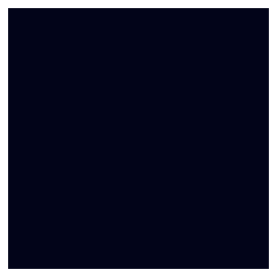

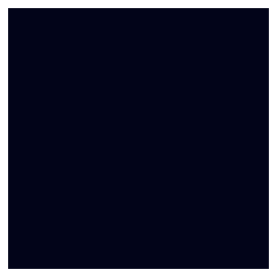

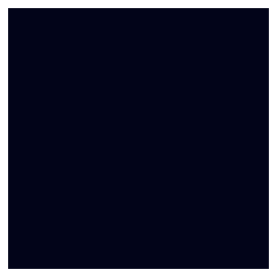

mc_dropout_sr_xray_2d_lanczos3


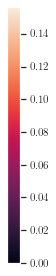

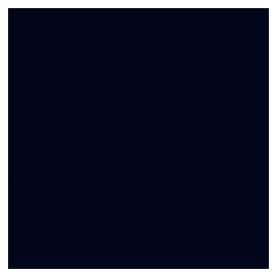

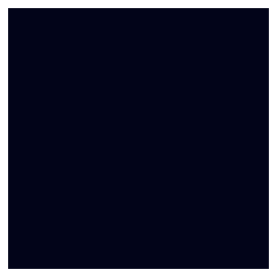

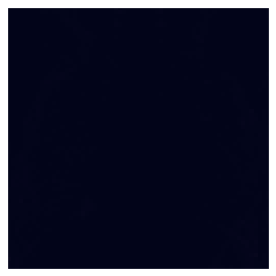

sgld_sr_xray_lanczos3


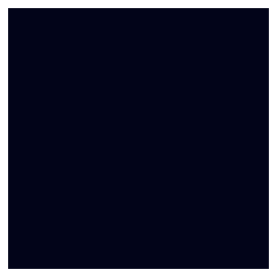

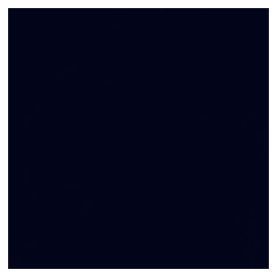

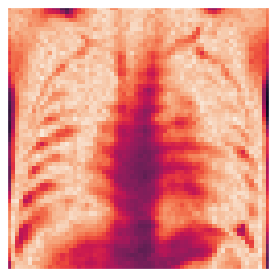

sgld_paper_sr_xray_lanczos3


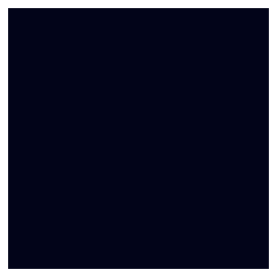

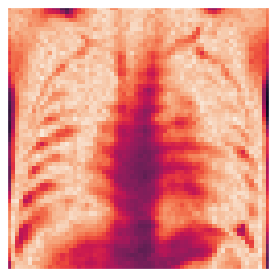

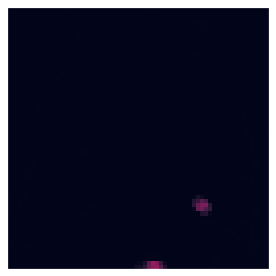

mean_field_sr_xray_gp_lanczos3


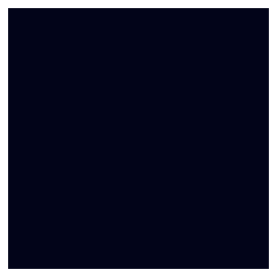

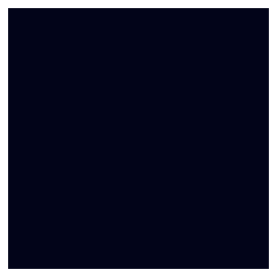

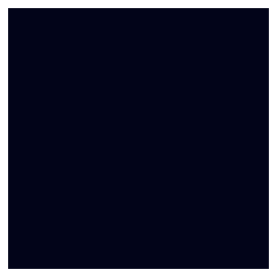

mc_dropout_sr_xray_2d_lanczos3


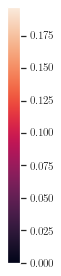

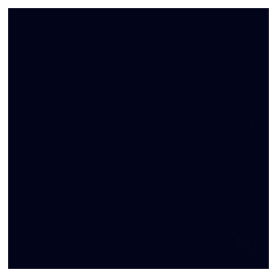

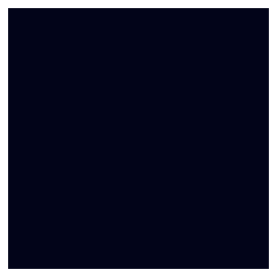

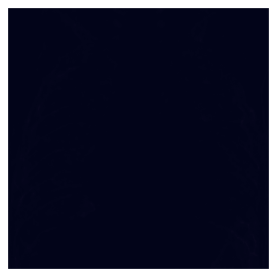

sgld_sr_xray_lanczos3


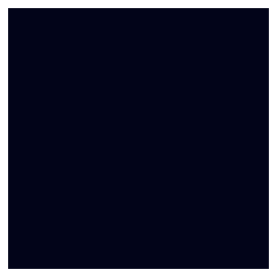

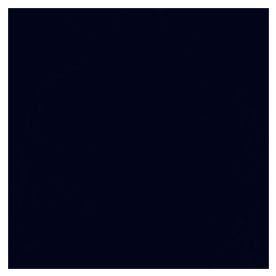

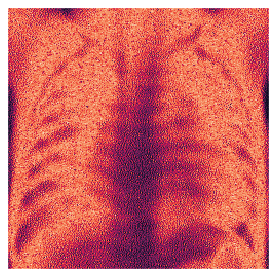

sgld_paper_sr_xray_lanczos3


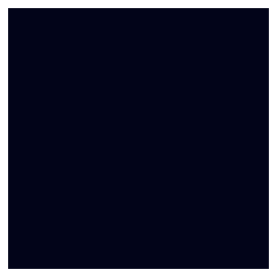

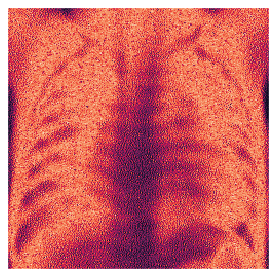

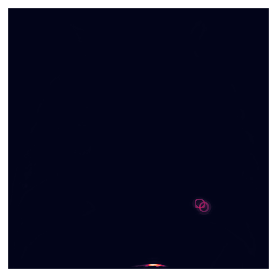

In [7]:
#ale_maps = ale_maps[1:]
#epi_maps = epi_maps[1:]
#uncert_maps = uncert_maps[1:]
for res, (ale_maps, epi_maps, uncert_maps) in zip(['LR', 'HR'], [[ale_LR_maps, epi_LR_maps, uncert_LR_maps], [ale_HR_maps, epi_HR_maps, uncert_HR_maps]]):
    _uncerts = np.array([ale_maps[:3], epi_maps[:3], uncert_maps[:3]])
    vmin = _uncerts.min()
    vmax = _uncerts.max()
    for i, (ale, epi, uncert, run) in enumerate(zip(ale_maps, epi_maps, uncert_maps, runs[1:])):
        print(run)
        for u, l in zip([ale, epi, uncert], ['ale', 'epi', 'uncert']):
            #fig, ax = plt.subplots(1,1)
            fig = plt.figure()
            im = plt.imshow(u, vmin=vmin, vmax=vmax)
            #plt.colorbar()
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs_sr/%s_%s_%s_same.pdf' % (run, l, res), bbox_inches='tight')
            plt.show()

            if i == 0 and l == 'uncert':
                fig, ax = plt.subplots(1,1, figsize=fig.get_size_inches())
                plt.colorbar(im, ax=ax)
                ax.remove()
                plt.tight_layout()
                plt.savefig('imgs_sr/same_%s_%s_colorbar' % (run, res), bbox_inches='tight')

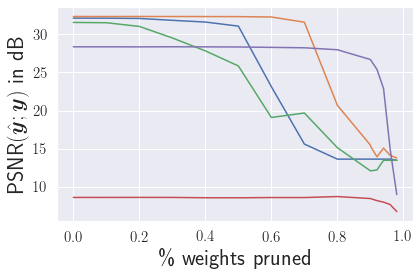

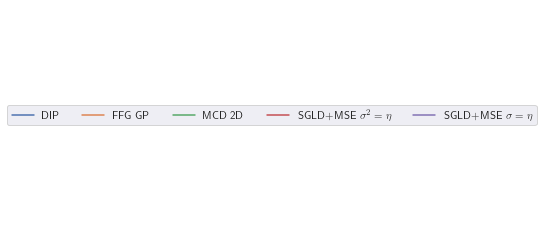

In [8]:
ys = [psnrs[run]['pruning'] for run in runs]
xs = [pruning_range for _ in runs]
np_plot(xs, ys, labels=labels, ylabel=r'PSNR$(\hat{\bm{y}};\bm{y})$ in dB', xlabel=r'\% weights pruned', sigma=0, 
        path='imgs_sr/%s_pruned_%s.pdf' % (to_compare, img_name), separate_legend=True)#, path='pruned_weights.pdf')

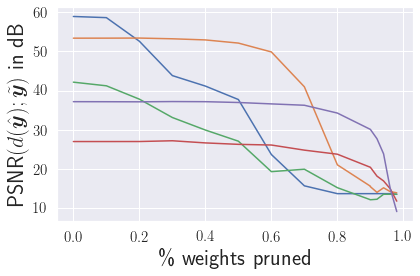

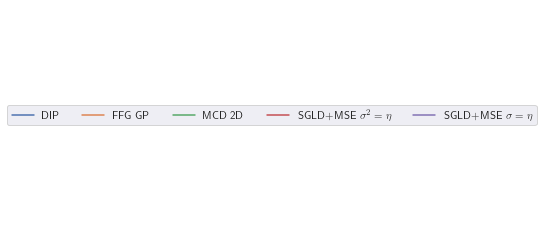

In [9]:
ys = [psnrs[run]['pruning_LR'] for run in runs]
xs = [pruning_range for _ in runs]
np_plot(xs, ys, labels=labels, ylabel=r'PSNR$(d(\hat{\bm{y}});\tilde{\bm{y}})$ in dB', xlabel=r'\% weights pruned', sigma=0, 
        path='imgs_sr/%s_pruned_LR%s.pdf' % (to_compare, img_name), separate_legend=True)#, path='pruned_weights.pdf')

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


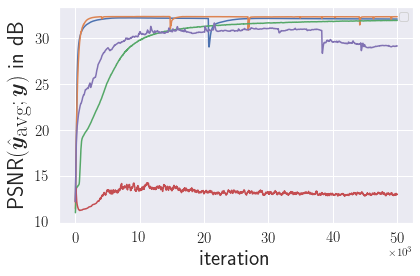

In [10]:
ys = [psnrs[run]['HR\_gt\_sm'] for run in runs]
xs = [range(len(psnrs[run]['HR\_gt\_sm'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'PSNR$(\hat{\bm{y}}_{\textrm{avg}};\bm{y})$ in dB', xtlf='sci', 
        path='imgs_sr/%s_psnrs%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


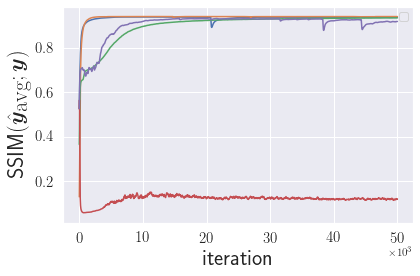

In [11]:
ys = [ssims[run]['HR\_gt\_sm'] for run in runs]
xs = [range(len(ssims[run]['HR\_gt\_sm'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'SSIM$(\hat{\bm{y}}_{\textrm{avg}};\bm{y})$', xtlf='sci', 
        path='imgs_sr/%s_ssims%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


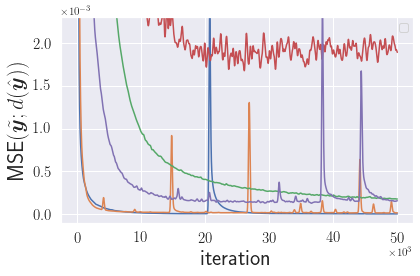

In [12]:
ys = [losses[run]['mse\_LR'] for run in runs]
xs = [range(len(losses[run]['mse\_LR'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'MSE$(\tilde{\bm{y}};d(\hat{\bm{y}}))$', sigma=100, ytlf='sci', xtlf='sci', 
        ylim=[-0.0001,0.0023], 
        path='imgs_sr/%s_mses_LR%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


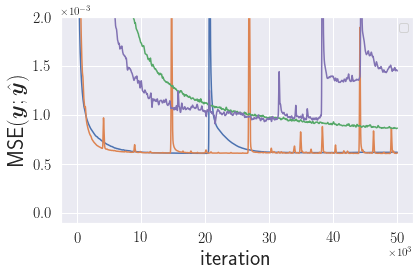

In [13]:
ys = [losses[run]['mse\_HR'] for run in runs]
xs = [range(len(losses[run]['mse\_HR'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'MSE$(\bm{y};\hat{\bm{y}})$', sigma=50, ytlf='sci', xtlf='sci', 
        ylim=[-0.0001,0.002], path='imgs_sr/%s_mses_HR%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


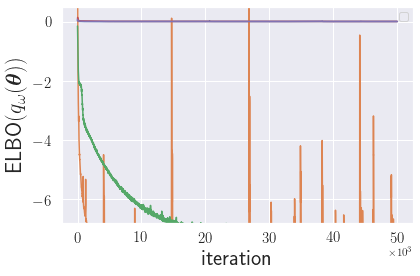

In [14]:
ys = [losses[run]['elbo'] for run in runs]
xs = [range(len(losses[run]['elbo'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'ELBO$(q_{\omega}(\bm{\theta}))$', xtlf='sci', ylim=[-6.8, 0.5], 
        path='imgs_sr/%s_elbos%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


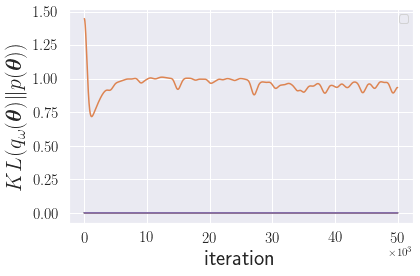

In [15]:
ys = [losses[run]['kl'] for run in runs]
xs = [range(len(losses[run]['kl'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'$KL(q_{\omega}(\bm{\theta})\|p(\bm{\theta}))$', sigma=400, xtlf='sci', 
        path='imgs_sr/%s_kls%s.pdf' % (to_compare, img_name))

No handles with labels found to put in legend.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/laves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


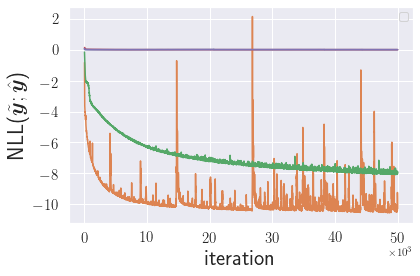

In [16]:
ys = [losses[run]['nll'] for run in runs]
xs = [range(len(losses[run]['nll'])) for _ in runs]
np_plot(xs, ys, labels=None, ylabel=r'NLL($\tilde{\bm{y}};\hat{\bm{y}}$)', xtlf='sci', 
        path='imgs_sr/%s_nlls%s.pdf' % (to_compare, img_name))